In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams

## Import and Pre-process Data

In [125]:
data_path = '../input/ckplus/CK+48'
data_dir_list = os.listdir(data_path)

img_rows=256
img_cols=256
num_channel=1

num_epoch=10

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-disgust

Loaded the images of dataset-sadness

Loaded the images of dataset-happy

Loaded the images of dataset-anger

Loaded the images of dataset-fear

Loaded the images of dataset-surprise

Loaded the images of dataset-contempt



(981, 48, 48, 3)

In [126]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:134]=0 #135
labels[135:188]=1 #54
labels[189:365]=2 #177
labels[366:440]=3 #75
labels[441:647]=4 #207
labels[648:731]=5 #84
labels[732:980]=6 #249

names = ['anger','contempt','disgust','fear','happy','sadness','surprise']

def getLabel(id):
    return ['anger','contempt','disgust','fear','happy','sadness','surprise'][id]

In [127]:
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
x_test=X_test

In [128]:
## Transfer Model Definition

In [129]:
from keras.applications import VGG16
#Load the VGG model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [130]:
import numpy as np
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.utils import plot_model
def define_model_original(base_model):
    inputs1 = Input(shape=(None, None, 3,))
    # Create the model
    model = Sequential()
 
    # Add the vgg convolutional base model
    model.add(base_model)
 
    # Add new layers
    model.add(Flatten())
    model.add(Dense(units=1024,activation="relu"))
    model.add(Dense(units=1024,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation="softmax"))
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='mode_original.png', show_shapes=True)
    return model 

def define_model_modified(base_model):
    inputs1 = Input(shape=(None, None, 3,))
    # Create the model
    model = Sequential()
 
    # Add the vgg convolutional base model
    model.add(base_model)
 
    # Add new layers
    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units=1000,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation="softmax"))
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='mode_modified.png', show_shapes=True)
    return model 

model_original = define_model_original(base_model)
model_modified = define_model_modified(base_model)
model_original.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model_modified.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_18 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_64 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_36 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_65 (Dense)             (None, 7)                 7175      
Total params: 16,296,775
Trainable params: 16,296,775
Non-trainable params: 0
_________________________________________

In [131]:
## Conduct k-Fold Cross-Validation

In [132]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False)

In [133]:
from keras.preprocessing.image import ImageDataGenerator
# Any results you write to the current directory are saved as output

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [135]:
BS = 8
EPOCHS = 200
result = []
scores_loss = []
scores_acc = []
k_no = 0

def fit_model(model, file_path, X_Train_, Y_Train, X_Test_, Y_Test):
    checkpoint = ModelCheckpoint(file_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
    early = EarlyStopping(monitor="loss", mode="min", patience=8)
    callbacks_list = [checkpoint, early]
    hist = model.fit_generator(aug.flow(X_Train_, Y_Train), epochs=EPOCHS,validation_data=(X_Test_, Y_Test), callbacks=callbacks_list, verbose=1)
    model.load_weights(file_path)
    result.append(model.predict(X_Test_))
    score = model.evaluate(X_Test_,Y_Test, verbose=0)
    scores_loss.append(score[0])
    scores_acc.append(score[1])
    
for train_index, test_index in kf.split(x):
    X_Train_ = x[train_index]
    Y_Train = y[train_index]
    X_Test_ = x[test_index]
    Y_Test = y[test_index]

    file_path_original = "/kaggle/working/weights_original_"+str(k_no)+".hdf5"
    file_path_modified = "/kaggle/working/weights_modified_"+str(k_no)+".hdf5"
    fit_model(model_original, file_path_original, X_Train_, Y_Train, X_Test_, Y_Test)
    fit_model(model_modified, file_path_modified, X_Train_, Y_Train, X_Test_, Y_Test)
    k_no+=1

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
25/25 [==============================] - 51s 2s/step - loss: 2.0790 - acc: 0.2336 - val_loss: 1.8870 - val_acc: 0.1878

Epoch 00001: loss improved from inf to 2.00140, saving model to ../working/weights_original_0.hdf5
Epoch 2/200
25/25 [==============================] - 49s 2s/step - loss: 1.8398 - acc: 0.2460 - val_loss: 1.9144 - val_acc: 0.2081

Epoch 00002: loss improved from 2.00140 to 1.86163, saving model to ../working/weights_original_0.hdf5
Epoch 3/200
25/25 [==============================] - 49s 2s/step - loss: 1.8890 - acc: 0.2813 - val_loss: 1.8691 - val_acc: 0.2081

Epoch 00003: loss did not improve from 1.86163
Epoch 4/200
25/25 [==============================] - 49s 2s/step - loss: 1.8312 - acc: 0.2662 - val_loss: 1.8656 - val_acc: 0.2081

Epoch 00004: loss improved from 1.86163 to 1.83346, saving model to ../working/weights_original_0.hdf5
Epoch 5/200
25/25 [==============================] - 49s 2s/step - loss: 1.8372 - acc: 0.2763 - val_loss: 1.8634 - val_a

KeyboardInterrupt: 

In [223]:
# get the weights from the previously run result, best weight is achieved at ../input/weights_modified_4.hdfs5
# value_min = min(scores_loss)
value_index = 3
print(value_index)

3


In [232]:
model_original.load_weights("../working/weights_original_"+str(value_index)+".hdf5")
model_modified.load_weights("../working/weights_modified_"+str(value_index)+".hdf5")

In [233]:
best_model = model_modified

## Evaluating Model

In [234]:
score = best_model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print(best_model.predict(test_image))
print(best_model.predict_classes(test_image))
print(y_test[0:1])

#predict
y_pred = best_model.predict(X_test)

Test Loss: 0.5455576181411743
Test accuracy: 0.807106614112854
(1, 48, 48, 3)
[[7.8758347e-01 2.1210670e-01 4.2523865e-05 5.8488022e-06 2.2265363e-04
  3.4165398e-05 4.6616001e-06]]
[0]
[[1. 0. 0. 0. 0. 0. 0.]]


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## Train and Validation Visualization

In [236]:
import re

epoches_num = 0
train_loss=[]
val_loss=[]
train_acc=[]
val_acc=[]

with open('../working/history_modified4.txt') as f:
    for line in f:
        matches = re.findall("\d+\.\d+", line)
        if len(matches) == 4:
            epoches_num = epoches_num + 1
            # loss: 1.3591 - acc: 0.4446 - val_loss: 1.1429 - val_acc: 0.5255
            train_loss.append(float(matches[0]))
            train_acc.append(float(matches[1]))
            val_loss.append(float(matches[2]))
            val_acc.append(float(matches[3]))
            
epochs = range(epoches_num)

<Figure size 432x288 with 0 Axes>

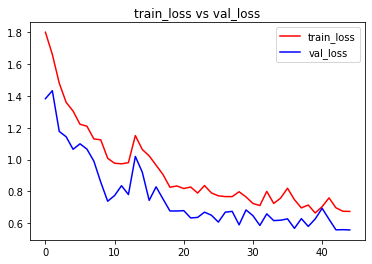

<Figure size 432x288 with 0 Axes>

In [237]:
# visualizing losses and accuracy
%matplotlib inline

plt.plot(epochs[:45],train_loss[:45],'r', label='train_loss')
plt.plot(epochs[:45],val_loss[:45],'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

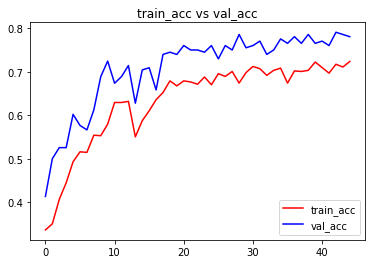

<Figure size 432x288 with 0 Axes>

In [238]:
plt.plot(epochs[:45],train_acc[:45],'r', label='train_acc')
plt.plot(epochs[:45],val_acc[:45],'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

## Confusion Matrix

In [239]:
from sklearn.metrics import confusion_matrix
results = best_model.predict_classes(X_test)
cm = confusion_matrix(np.where(y_test == 1)[1], results)
#cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]

In [240]:
import seaborn as sns
import pandas as pd
label_mapdisgust = ['anger','contempt','disgust','fear','happy','sadness','surprise']
#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = label_mapdisgust,
                     columns = label_mapdisgust
                    )
final_cm = cm_df
final_cm

,anger,contempt,disgust,fear,happy,sadness,surprise
anger,25,0,0,0,0,0,0
contempt,7,0,2,0,0,0,0
disgust,0,0,44,0,0,0,0
fear,0,0,10,0,0,0,0
happy,0,0,8,0,25,4,0
sadness,0,0,0,0,0,4,7
surprise,0,0,0,0,0,0,61


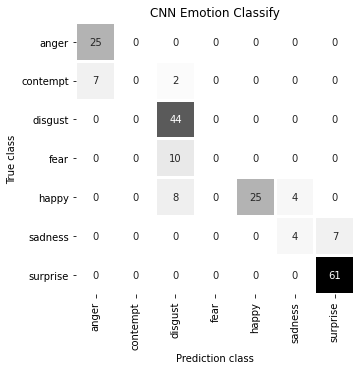

In [241]:
plt.figure(figsize = (5,5))
sns.heatmap(final_cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Emotion Classify')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

## ROC Curve

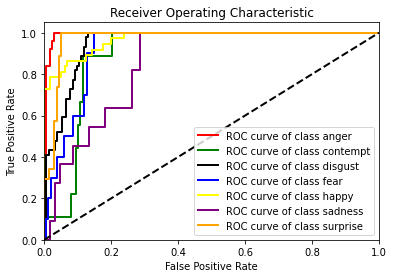

In [242]:
from sklearn.metrics import roc_curve,auc
from itertools import cycle

new_label = ['anger','contempt','disgust','fear','happy','sadness','surprise']
final_label = new_label
new_class = 7

#ravel flatten the array into single vector
y_pred_ravel = y_pred.ravel()
lw = 2

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(new_class):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#colors = cycle(['red', 'green','black'])
colors = cycle(['red', 'green','black','blue', 'yellow','purple','orange'])
for i, color in zip(range(new_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0}'''.format(final_label[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()